In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install pykan
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from kan import KAN   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 1.9 MB/s eta 0:00:00a 0:00:01


# 1. Load and preprocess the Iris dataset

In [11]:
iris = load_iris()
X = iris.data          
y = iris.target        

print(f"Shape: ({len(X),len(X[0])})")
print(f"target:{set(y)}")

Shape: ((150, 4))
target:{0, 1, 2}


## train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## standardize features

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## convert to torch tensors

In [14]:

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test,  dtype=torch.long)

# 2. Define the KAN model

In [15]:
# width = [input_dim, hidden1, ..., output_dim]
input_dim = 4   # sepal length, sepal width, petal length, petal width
hidden_dim = 8
num_classes = 3

model = KAN(
    width=[input_dim, hidden_dim, num_classes],
    grid=5,     # number of spline intervals
    k=3,        # spline order (cubic)
    seed=0
)

checkpoint directory created: ./model
saving model version 0.0


# 3. Training setup

In [16]:

criterion = nn.CrossEntropyLoss()  # expects raw logits
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200
batch_size = 32

def get_batches(X, y, batch_size):
    n = X.shape[0]
    indices = torch.randperm(n)
    for i in range(0, n, batch_size):
        idx = indices[i:i + batch_size]
        yield X[idx], y[idx]


# 4. Training loop

In [17]:

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for xb, yb in get_batches(X_train, y_train, batch_size):
        optimizer.zero_grad()
        logits = model(xb)           # shape: (batch_size, 3)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    avg_loss = running_loss / X_train.size(0)

    # evaluate on test set every 20 epochs
    if epoch % 20 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            test_logits = model(X_test)
            preds = torch.argmax(test_logits, dim=1)
            acc = (preds == y_test).float().mean().item()
        print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Test Acc: {acc:.4f}")


Epoch 001 | Loss: 1.0503 | Test Acc: 0.8667
Epoch 020 | Loss: 0.7590 | Test Acc: 0.8667
Epoch 040 | Loss: 0.3716 | Test Acc: 0.9667
Epoch 060 | Loss: 0.1842 | Test Acc: 0.9667
Epoch 080 | Loss: 0.1133 | Test Acc: 0.9667
Epoch 100 | Loss: 0.0837 | Test Acc: 0.9667
Epoch 120 | Loss: 0.0679 | Test Acc: 0.9667
Epoch 140 | Loss: 0.0576 | Test Acc: 0.9667
Epoch 160 | Loss: 0.0502 | Test Acc: 0.9667
Epoch 180 | Loss: 0.0442 | Test Acc: 0.9667
Epoch 200 | Loss: 0.0392 | Test Acc: 0.9667


# --- EDGE FUNCTION VISUALIZATION (KAN NATIVE) ---

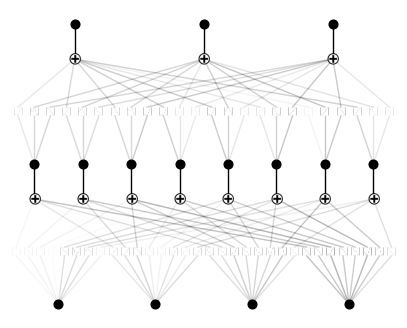

In [19]:


# 1) Run one forward pass so KAN knows the data range
model(X_train)

# 2) Plot all edge functions
model.plot()              # default visualization



# increasing "beta" to sharpen activations visually

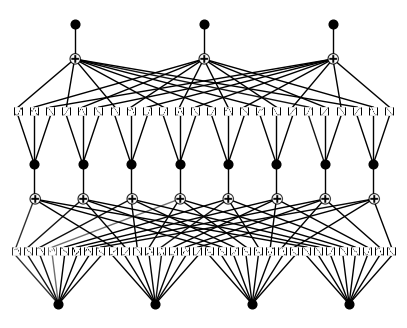

In [20]:

model.plot(beta=100)


# --- PRUNE UNIMPORTANT EDGES AND RE-PLOT ---


## 1) Prune but keep same shape

saving model version 0.1


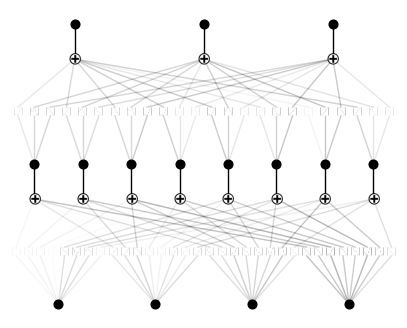

In [22]:


model.prune()          # marks weak edges in an internal mask
model.plot()  # only show strong edges visually




## 2) shrinking the architecture:

saving model version 0.1


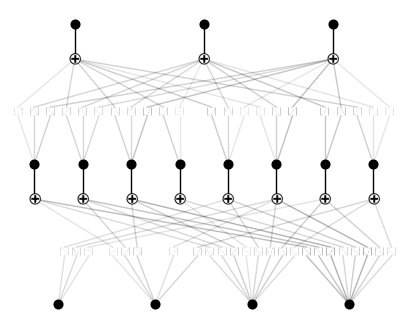

In [24]:

model = model.prune()
model(X_train)
model.plot()